In [4]:
from report.io.trajectory_parser import parse_trajectory
from report.data.geometry import Geometry

import pygeos
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import numpy as np

# Setup geometry & measurement area

In [5]:
geometry = pygeos.polygons([(-9, 0), (-9, 5), (9, 5), (9, 0), (-9, 0)])
geometry_pita = Geometry(geometry)

ma = pygeos.polygons([(-1.5, 0), (-1.5, 5), (1.5, 5), (1.5, 0), (-1.5, 0)])

direction = np.array([-1, 0])

traj = parse_trajectory("demos/uni-directional/traj_UNI_CORR_500_01.txt")
# traj = parse_trajectory("fd_review/uni/traj_UNI_CORR_500_09.txt")

# Density

## Classic density

In [ ]:
from report.methods.density_calculator import compute_classic_density

classic_density = compute_classic_density(traj.data, ma)
classic_density

In [ ]:
classic_density.reset_index().plot.line(x="frame", y="classic density")

## Voronoi density

In [ ]:
from report.methods.density_calculator import compute_voronoi_density

density_voronoi, individual = compute_voronoi_density(traj.data, ma, geometry_pita)

In [ ]:
density_voronoi

In [ ]:
individual

In [ ]:
density_voronoi.reset_index().plot.line(x="frame", y="voronoi density")

## Comparision

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.plot(
    classic_density.reset_index().frame,
    classic_density["classic density"].values,
    label="classic",
    lw=3,
)
plt.plot(
    density_voronoi.reset_index().frame, density_voronoi["voronoi density"], label="voronoi", lw=3
)
plt.xlabel("frame")
plt.ylabel("rho / 1/m^2")
plt.legend()
plt.grid()
plt.show()

## Plot voronoi cells

In [ ]:
import pandas as pd

frame_start = 1200

for frame in range(frame_start, frame_start + 100, 20):
    df_frame = individual[individual.frame == frame]
    df_frame = pd.merge(traj.data, df_frame, on=["ID", "frame"])

    fig = plt.figure(figsize=(15, 20))
    ax1 = fig.add_subplot(111, aspect="equal")

    ax1.plot(*pygeos.to_shapely(geometry).exterior.xy, color="k")
    ax1.plot(*pygeos.to_shapely(ma).exterior.xy, color="k")

    for _, row in df_frame.iterrows():
        p = ax1.plot(*pygeos.to_shapely(row[6]).exterior.xy)
        ax1.scatter(row[2], row[3])
        ax1.add_patch(
            PolygonPatch(
                pygeos.to_shapely(row[6]), alpha=0.1, zorder=2, fc=p[-1].get_color(), ec="none"
            )
        )
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    plt.show()

# Velocity

In [ ]:
from report.methods.velocity_calculator import compute_individual_velocity

individual_speed = compute_individual_velocity(traj.data, traj.frame_rate, 5)
individual_speed

In [ ]:
individual_speed.reset_index().plot.scatter(x="frame", y="speed")

In [ ]:
individual_speed_direction = compute_individual_velocity(traj.data, traj.frame_rate, 5, direction)
individual_speed_direction

In [ ]:
individual_speed.reset_index().plot.scatter(x="frame", y="speed")

## Mean speed (all)

In [ ]:
from report.methods.velocity_calculator import compute_mean_velocity_per_frame

mean_speed, individual_speed = compute_mean_velocity_per_frame(traj.data, traj.frame_rate, 5)
mean_speed

In [ ]:
mean_speed.reset_index().plot.scatter(x="frame", y="speed")

In [ ]:
mean_speed_direction, individual_speed_direction = compute_mean_velocity_per_frame(
    traj.data, traj.frame_rate, 5, direction
)
mean_speed_direction

## Mean speed (in measurement area)

In [ ]:
from report.methods.method_utils import get_peds_in_area
from report.methods.velocity_calculator import compute_mean_velocity_per_frame

peds_in_area = get_peds_in_area(traj.data, ma)
mean_speed_area, individual_speed_area = compute_mean_velocity_per_frame(
    peds_in_area, traj.frame_rate, 5
)

In [ ]:
mean_speed_area.reset_index().plot.scatter(x="frame", y="speed")

In [ ]:
mean_speed_area_direction, individual_speed_area_direction = compute_mean_velocity_per_frame(
    peds_in_area, traj.frame_rate, 5, direction
)

In [ ]:
mean_speed_area_direction.reset_index().plot.scatter(x="frame", y="speed")

## Voronoi speed

In [ ]:
from report.methods.density_calculator import (
    _compute_individual_voronoi_polygons,
    _compute_intersecting_polygons,
)
from report.methods.velocity_calculator import compute_individual_velocity, compute_voronoi_velocity

In [ ]:
individual_voronoi = _compute_individual_voronoi_polygons(traj.data, geometry_pita)
intersecting_voronoi = _compute_intersecting_polygons(individual_voronoi, ma)

In [ ]:
voronoi_velocity = compute_voronoi_velocity(traj.data, intersecting_voronoi, traj.frame_rate, 5, ma)
voronoi_velocity

In [ ]:
voronoi_velocity.reset_index().plot.scatter(x="frame", y="voronoi speed")

In [ ]:
voronoi_velocity_direction = compute_voronoi_velocity(
    traj.data, intersecting_voronoi, traj.frame_rate, 5, ma, direction
)
voronoi_velocity_direction

## Comparison mean velocity vs voronoi velocity

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(voronoi_velocity.reset_index().frame, voronoi_velocity, label="voronoi")
plt.scatter(
    voronoi_velocity_direction.reset_index().frame,
    voronoi_velocity_direction,
    label="voronoi direction",
)
plt.scatter(mean_speed_area.reset_index().frame, mean_speed_area, label="classic")
plt.scatter(
    mean_speed_area_direction.reset_index().frame,
    mean_speed_area_direction,
    label="classic direction",
)
plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.legend()
plt.grid()
plt.show()

# CCM

In [6]:
from report.methods.method_CCM import _run_method_ccm
from report.data.configuration import ConfigurationMethodCCM, ConfigurationVelocity

In [7]:
config_ccm = ConfigurationMethodCCM(0.05, 0)
config_velocity = ConfigurationVelocity(10, np.array([1, 0]), False)
line = pygeos.linestrings([[0, 0], [0, 5]])

In [8]:
# %%timeit
mean, individual = _run_method_ccm(config_ccm, traj, line, geometry_pita, config_velocity)

/home/tobias/development/jupedsim/venv-jpsreport-python/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in intersection
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='frame'>

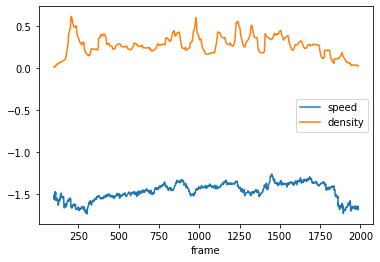

In [92]:
mean.plot()

In [14]:
from report.data.configuration import ConfigurationMethodCCM
from report.methods.method_CCM import ResultMethodCCM

result = _run_method_ccm(config_ccm, traj, line, geometry_pita, config_velocity)

/home/tobias/development/jupedsim/venv-jpsreport-python/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in intersection
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
ccm = ResultMethodCCM(result[0], result[1])

In [17]:
ccm.df_individual

,ID,frame,individual voronoi,intersection voronoi,speed,density
0,1,98,"POLYGON ((-9 5, 9 5, 9 0, -9 0, -9 5))","POLYGON ((0 5, 0.05 5, 0.05 0, 0 0, -0.05 0, -...",-1.55625,0.005556
1,1,99,"POLYGON ((-9 5, 9 5, 9 0, -9 0, -9 5))","POLYGON ((0 5, 0.05 5, 0.05 0, 0 0, -0.05 0, -...",-1.53400,0.005556
2,1,100,"POLYGON ((-9 5, 9 5, 9 0, -9 0, -9 5))","POLYGON ((0 5, 0.05 5, 0.05 0, 0 0, -0.05 0, -...",-1.51875,0.005556
3,1,101,"POLYGON ((-9 5, 9 5, 9 0, -9 0, -9 5))","POLYGON ((0 5, 0.05 5, 0.05 0, 0 0, -0.05 0, -...",-1.50825,0.005556
4,1,102,"POLYGON ((-9 5, 9 5, 9 0, -9 0, -9 5))","POLYGON ((0 5, 0.05 5, 0.05 0, 0 0, -0.05 0, -...",-1.53275,0.005556
...,...,...,...,...,...,...
25531,136,1985,"POLYGON ((-9 1.978, -9 4.065, -1.7 2.652, -9 1...",POLYGON EMPTY,-1.81600,0.000000
25532,137,1985,"POLYGON ((-1.7 2.652, -9 4.065, -9 5, 9 5, 9 2...","POLYGON ((0 5, 0.05 5, 0.05 2.698, -0.05 2.696...",-1.49000,0.006471
25533,138,1985,"POLYGON ((9 2.936, 9 0, -9 0, -9 1.978, -1.7 2...","POLYGON ((0 0, -0.05 0, -0.05 2.696, 0.05 2.69...",-1.75225,0.005763
25534,137,1986,"POLYGON ((-9 2.456, -9 5, 9 5, 9 2.957, -9 2.4...","POLYGON ((0 5, 0.05 5, 0.05 2.708, -0.05 2.705...",-1.53550,0.005556
